### Precondition
Here the credentials of the neo4j database and the URI have to be inserted. The database needs to run in order to execute this code. I used Neo4j Desktop (https://neo4j.com/download/). Additionally the database has to be populated by executing the jupyter notebook populate_db.ipynb in the kg_construction directory.

In [1]:
from neo4j import GraphDatabase
import pandas as pd
import numpy as np

SEED = 11717659

URI = "neo4j://localhost:7687"
AUTH = ("neo4j", "password")
driver = GraphDatabase.driver(URI, auth=AUTH)

### Fetch Triples from Neo4j Database

In [2]:
def run_query(driver, query):
    with driver.session() as session:
        result = session.run(query)
        return [record.data() for record in result]

# Define queries to extract the data
query_movies_titles = """
MATCH (m:Movie)
RETURN m.movie_id AS movie_id, m.title AS title
"""
query_movie_years = """
MATCH (m:Movie)-[:RELEASED_IN]->(y:Year)
RETURN m.movie_id AS movie_id, y.year AS year
"""
query_movie_genres = """
MATCH (m:Movie)-[:OF_GENRE]->(g:Genre)
RETURN m.movie_id AS movie_id, g.name AS genre
"""
query_user_relations = """
MATCH (u:User)-[r:RATED]->(m:Movie)
RETURN u.user_id AS user_id, m.movie_id AS movie_id, r.rating AS rating
"""
# Extract data
movie_titles_data = run_query(driver, query_movies_titles)
movie_years_data = run_query(driver, query_movie_years)
movie_genres_data = run_query(driver, query_movie_genres)
ratings_data = run_query(driver, query_user_relations)

# Convert to DataFrame
movie_titles_df = pd.DataFrame(movie_titles_data)
movie_years_df = pd.DataFrame(movie_years_data)
movie_genres_df = pd.DataFrame(movie_genres_data)
ratings_df = pd.DataFrame(ratings_data)

ratings_df["user_id"] = ratings_df["user_id"].astype(int)

# Preview the data
display(movie_titles_df)
display(movie_years_df)
display(movie_genres_df)
display(ratings_df)

,movie_id,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)
...,...,...
6717,193579,Jon Stewart Has Left the Building (2015)
6718,193581,Black Butler: Book of the Atlantic (2017)
6719,193583,No Game No Life: Zero (2017)
6720,193585,Flint (2017)


,movie_id,year
0,69,1995
1,136297,1995
2,132084,1995
3,56022,1995
4,51357,1995
...,...,...
6717,183911,2018
6718,183897,2018
6719,183611,2018
6720,182715,2018


,movie_id,genre
0,590,Adventure
1,191005,Adventure
2,189333,Adventure
3,188833,Adventure
4,187595,Adventure
...,...,...
15813,8600,Film-Noir
15814,25825,Film-Noir
15815,26701,Film-Noir
15816,31545,Film-Noir


,user_id,movie_id,rating
0,135,1197,5.0
1,135,1517,5.0
2,135,3740,5.0
3,135,1674,4.0
4,135,180,4.0
...,...,...,...
25540,498,216,5.0
25541,498,454,5.0
25542,498,318,5.0
25543,54,420,2.0


### Reconstruct KG in memory
The title is not included here, as it is redundant for the construction of embeddings

In [3]:
import networkx as nx
from node2vec import Node2Vec
import numpy as np

G = nx.Graph()

movies = movie_titles_df["movie_id"].unique()
years = movie_years_df["year"].unique()
genres = movie_genres_df["genre"].unique()
users = ratings_df["user_id"].unique()

# Insert Nodes
for movie in movies:
    G.add_node(f"m:{movie}", type="Movie")
for year in years:
    G.add_node(f"y:{year}", type="Year")
for genre in genres:
    G.add_node(f"g:{genre}", type="Genre")
for user in users:
    G.add_node(f"u:{user}", type="User")
    
# Insert Edges
for index, row in movie_years_df.iterrows():
    G.add_edge(f"m:{row["movie_id"]}", f"y:{row["year"]}")
for index, row in movie_genres_df.iterrows():
    G.add_edge(f"m:{row["movie_id"]}", f"g:{row["genre"]}")
for index, row in ratings_df.iterrows():
    G.add_edge(f"u:{row["user_id"]}", f"m:{row["movie_id"]}", weight=row["rating"])
    
print(G)

d:\kg\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Graph with 12812 nodes and 48085 edges


### Apply Node2Vec to generate embeddings
Fitting took me 30min for 14k nodes sand 48k edges

In [4]:
# node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4, weight_key='weight')
node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4, weight_key='weight')
model = node2vec.fit(window=10, min_count=1, batch_words=4)
node_embeddings = {node: model.wv[node] for node in G.nodes()}

Computing transition probabilities: 100%|██████████| 12812/12812 [01:23<00:00, 153.75it/s] 


In [5]:
print(G.nodes())
node_embeddings = {node: model.wv[node] for node in G.nodes()}

['m:1', 'm:2', 'm:3', 'm:4', 'm:5', 'm:6', 'm:7', 'm:8', 'm:9', 'm:10', 'm:11', 'm:12', 'm:13', 'm:14', 'm:15', 'm:16', 'm:17', 'm:18', 'm:19', 'm:20', 'm:21', 'm:22', 'm:23', 'm:24', 'm:25', 'm:26', 'm:27', 'm:28', 'm:29', 'm:31', 'm:32', 'm:34', 'm:36', 'm:39', 'm:40', 'm:41', 'm:42', 'm:43', 'm:44', 'm:45', 'm:46', 'm:47', 'm:48', 'm:49', 'm:50', 'm:52', 'm:57', 'm:58', 'm:60', 'm:61', 'm:62', 'm:63', 'm:64', 'm:65', 'm:66', 'm:68', 'm:69', 'm:70', 'm:71', 'm:72', 'm:73', 'm:74', 'm:75', 'm:76', 'm:79', 'm:81', 'm:82', 'm:85', 'm:86', 'm:87', 'm:88', 'm:89', 'm:92', 'm:93', 'm:94', 'm:95', 'm:97', 'm:99', 'm:100', 'm:101', 'm:103', 'm:104', 'm:105', 'm:107', 'm:110', 'm:111', 'm:112', 'm:116', 'm:119', 'm:122', 'm:123', 'm:125', 'm:129', 'm:132', 'm:135', 'm:137', 'm:140', 'm:141', 'm:144', 'm:145', 'm:147', 'm:148', 'm:150', 'm:151', 'm:152', 'm:153', 'm:154', 'm:155', 'm:157', 'm:158', 'm:159', 'm:160', 'm:161', 'm:162', 'm:163', 'm:164', 'm:165', 'm:166', 'm:168', 'm:169', 'm:170

In [6]:
movie_embeddings = {id: embedding for id, embedding in node_embeddings.items() if id.startswith("m:")}
user_embeddings = {id: embedding for id, embedding in node_embeddings.items() if id.startswith("u:")}
genre_embeddings = {id: embedding for id, embedding in node_embeddings.items() if id.startswith("g:")}
year_embeddings = {id: embedding for id, embedding in node_embeddings.items() if id.startswith("y:")}

### Dimensionality Reduction via PCA

In [7]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

movie_embedding_vectors = list(movie_embeddings.values())
user_embedding_vectors = list(user_embeddings.values())
genre_embedding_vectors = list(genre_embeddings.values())
year_embedding_vectors = list(year_embeddings.values())

pca = PCA(n_components=2)
movies_rep = pca.fit_transform(movie_embedding_vectors)
users_rep = pca.fit_transform(user_embedding_vectors)
genres_rep = pca.fit_transform(genre_embedding_vectors)
years_rep = pca.fit_transform(year_embedding_vectors)

print("PCA Explained Variance:", pca.explained_variance_ratio_)

PCA Explained Variance: [0.05322296 0.04968777]


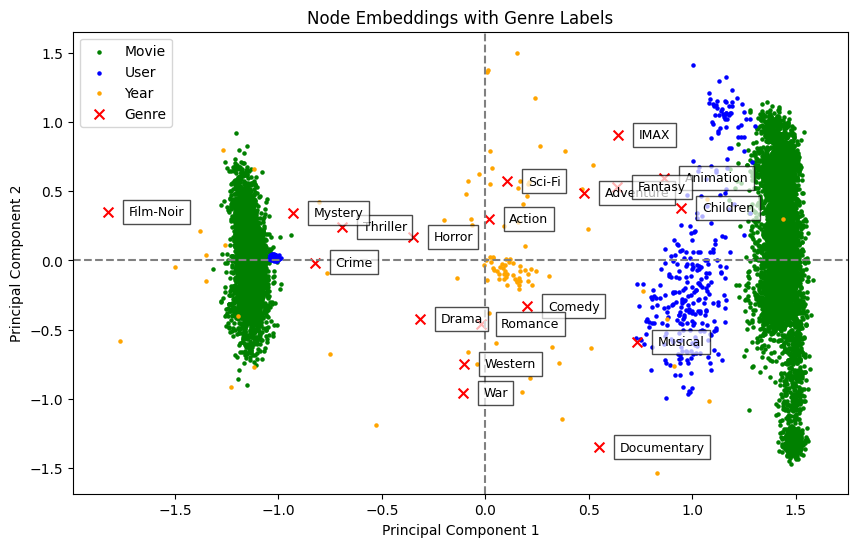

In [45]:

plt.figure(figsize=(10, 6))
plt.axvline(x=0, color='gray', linestyle='--')
plt.axhline(y=0, color='gray', linestyle='--')
plt.scatter(movies_rep[:, 0], movies_rep[:, 1], s=5, c='green', marker='o', label="Movie")
plt.scatter(users_rep[:, 0], users_rep[:, 1], s=5, c='blue', marker='o', label="User")
plt.scatter(years_rep[:, 0], years_rep[:, 1], s=5, c='orange', marker='o', label="Year")
plt.scatter(genres_rep[:, 0], genres_rep[:, 1], s=50, c='red', marker='x', label="Genre")

for i in range (0, len(genres)):
    plt.text(genres_rep[i, 0] + 0.1, genres_rep[i, 1] - 0.025, genres[i], fontsize=9, bbox=dict(facecolor='white', alpha=0.7))  # Slightly offset the text

plt.title("Node Embeddings with Genre Labels")
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

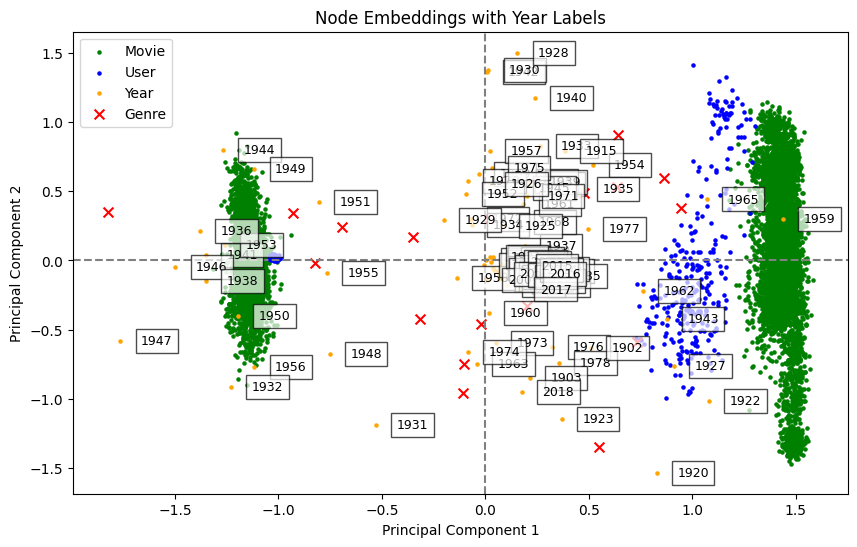

In [46]:

plt.figure(figsize=(10, 6))
plt.axvline(x=0, color='gray', linestyle='--')
plt.axhline(y=0, color='gray', linestyle='--')
plt.scatter(movies_rep[:, 0], movies_rep[:, 1], s=5, c='green', marker='o', label="Movie")
plt.scatter(users_rep[:, 0], users_rep[:, 1], s=5, c='blue', marker='o', label="User")
plt.scatter(years_rep[:, 0], years_rep[:, 1], s=5, c='orange', marker='o', label="Year")
plt.scatter(genres_rep[:, 0], genres_rep[:, 1], s=50, c='red', marker='x', label="Genre")

for i in range (0, len(years)):
    plt.text(years_rep[i, 0] + 0.1, years_rep[i, 1] - 0.025, years[i], fontsize=9, bbox=dict(facecolor='white', alpha=0.7))  # Slightly offset the text

plt.title("Node Embeddings with Year Labels")
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

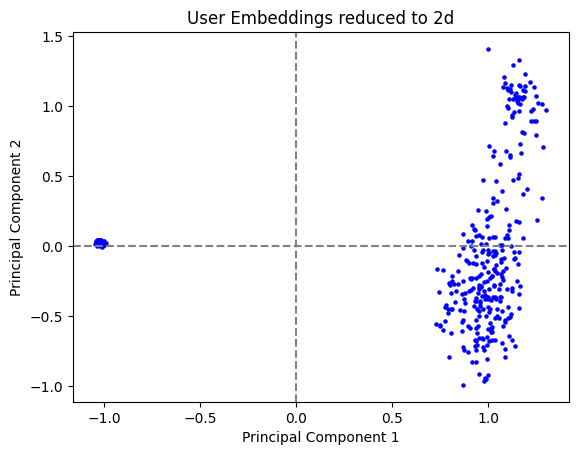

In [48]:
plt.figure()
plt.axvline(x=0, color='gray', linestyle='--')
plt.axhline(y=0, color='gray', linestyle='--')
plt.scatter(users_rep[:, 0], users_rep[:, 1], s=5, c='blue', marker='o')
plt.title("User Embeddings")
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [9]:
user_embeddings_df = pd.DataFrame(list(user_embeddings.items()), columns=["user_id", "embedding"])
user_embeddings_df["user_id"] = user_embeddings_df["user_id"].apply(lambda x: x[2:])
user_embeddings_df

,user_id,embedding
0,135,"[0.0084187295, -0.011422601, 0.010948958, 0.00..."
1,599,"[-0.0072322655, -0.007003177, -0.008986758, -0..."
2,327,"[-0.014639506, -0.0073977653, 0.014896013, -0...."
3,307,"[-0.011370277, -0.013598334, -0.014922578, 0.0..."
4,100,"[0.0075712632, -7.771514e-05, -0.00092531554, ..."
...,...,...
605,468.0,"[0.6121021, -0.48489144, 0.23722132, -0.531278..."
606,259.0,"[1.0395893, -0.5344237, 0.8785067, -0.10896299..."
607,155.0,"[0.4867024, -0.9305382, 0.08223984, -0.0810140..."
608,498.0,"[0.54792, -0.76682687, 0.085226655, -0.2962154..."


### Cluster User Nodes

KMeans clustering is applied on the full dimensionality of the user embeddings. For the visualization the first two principal components are used.

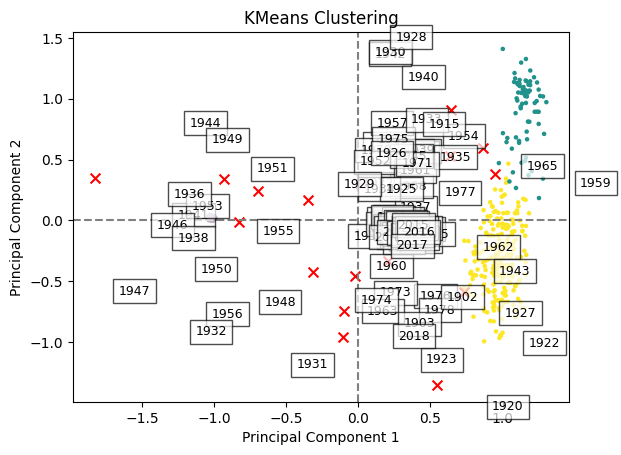

In [49]:
from sklearn.cluster import KMeans

df = pd.DataFrame(user_embeddings.values())
X = df.to_numpy()
X.shape

kmeans = KMeans(n_clusters=3, random_state=42)
user_clusters = kmeans.fit_predict(X)

# Create a mesh grid
x_min, x_max = users_rep[:, 0].min() - 1, users_rep[:, 0].max() + 1
y_min, y_max = users_rep[:, 1].min() - 1, users_rep[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

plt.axvline(x=0, color='gray', linestyle='--')
plt.axhline(y=0, color='gray', linestyle='--')

# Plot the original data points and cluster centers
plt.scatter(users_rep[:, 0], users_rep[:, 1], c=user_clusters, s=5, cmap='viridis', marker="o")
centers = kmeans.cluster_centers_
plt.title('KMeans Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.show()

In order to visualize the exact boundaries and centers of the clusters, this cell applies the KMeans clustering directly on the two first principal components.

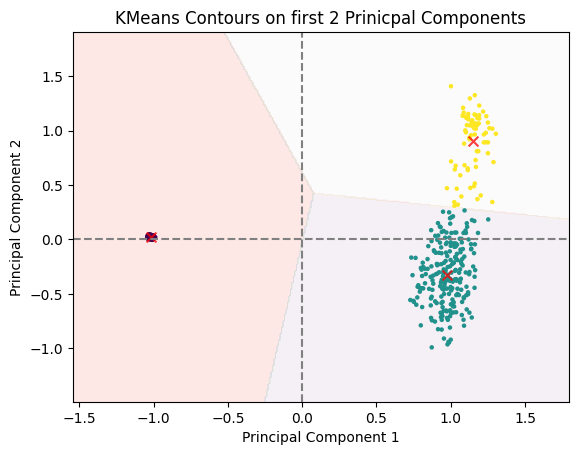

In [55]:
kmeans = KMeans(n_clusters=3, random_state=42)
user_clusters = kmeans.fit_predict(users_rep)

# Create a mesh grid
x_min, x_max = users_rep[:, 0].min() - 0.5, users_rep[:, 0].max() + 0.5
y_min, y_max = users_rep[:, 1].min() - 0.5, users_rep[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

# Predict on the mesh grid to get the boundaries
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.axvline(x=0, color='gray', linestyle='--')
plt.axhline(y=0, color='gray', linestyle='--')

# Plot the decision boundary by assigning a color in the mesh grid
plt.contourf(xx, yy, Z, alpha=0.3, cmap='Pastel1')

# Plot the original data points and cluster centers
plt.scatter(users_rep[:, 0], users_rep[:, 1], c=user_clusters, s=5, cmap='viridis', marker="o")
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=50, alpha=0.75, marker='x')  # cluster centers

plt.title('KMeans Contours on first 2 Prinicpal Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()